In [1]:
import collections
# Prepare paths to local utilities
import os
import sys

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
is_kaggle = (os.environ.get("PWD", "") == "/kaggle/working")
print(f"Are we running in Kaggle? {is_kaggle}")

Are we running in Kaggle? False


In [7]:
if not is_kaggle:
    models_path = os.path.abspath(os.path.join('..', 'model'))
    utils_path = os.path.abspath(os.path.join('..', 'util'))
    sys.path.append(models_path)
    sys.path.append(utils_path)

    %load_ext autoreload
    %autoreload 2

    from download.DataDownloader import DataDownloader
    from collect.DataframeCollector import DataframeCollector
    from collect.TestSetSplitter import TestSetSplitter
    from collect.DatasetPreparation import DatasetPreparation
    from reservoir.HierarchyESNCuda import HierarchyESNCuda as HierarchyESN
    from reservoir.ESNUtil import generate_input_weights

else:
    from datadownloader.datadownloader import DataDownloader
    from dataframecollector.dataframecollector import DataframeCollector
    from testsetsplitter.testsetsplitter import TestSetSplitter
    from hierarchyesn.HierarchyESNCuda import HierarchyESNCuda as HierarchyESN
    from esnutil.esnutil import generate_input_weights

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import contextlib

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    '''
    Context manager to patch joblib to report into tqdm progress bar given as argument
    :param tqdm_object: The tqdm progress bar
    '''
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [10]:
data_preparation = DatasetPreparation()

input_features = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
output_features = ['label']

data_preparation.prepare_dataset('har70plus', input_features, output_features)

Dataset already downloaded
Discovered  18  csv files in  E:\PyCharm\COM6906-Dissertation\data\har70plus
Loading the csv files into dataframes
Loaded  18  dataframes
Concatenating the dataframes
Data shape:  [(103860, 9), (131367, 9), (116413, 9), (150758, 9), (87006, 9), (122714, 9), (120125, 9), (130494, 9), (121763, 9), (122061, 9), (128063, 9), (119310, 9), (123599, 9), (101510, 9), (153517, 9), (138278, 9), (147045, 9), (141714, 9)]
Number of frames in training set: 17
Number of frames in validation set: 17
Number of frames in testing set: 18
X_train shape: (1357646, 6), Y_train shape: (1357646, 1)
X_val shape: (339404, 6), Y_val shape: (339404, 1)
X_test shape: (562547, 6), Y_test shape: (562547, 1)
Y_train encoded shape: (1357646, 7)
Y_val encoded shape: (339404, 7)
Y_test encoded shape: (562547, 7)
Y_train decoded shape: (1357646, 1)
Y_val decoded shape: (339404, 1)
Y_test decoded shape: (562547, 1)
X_train scaled shape: (1357646, 6)
X_val scaled shape: (339404, 6)
X_test scaled

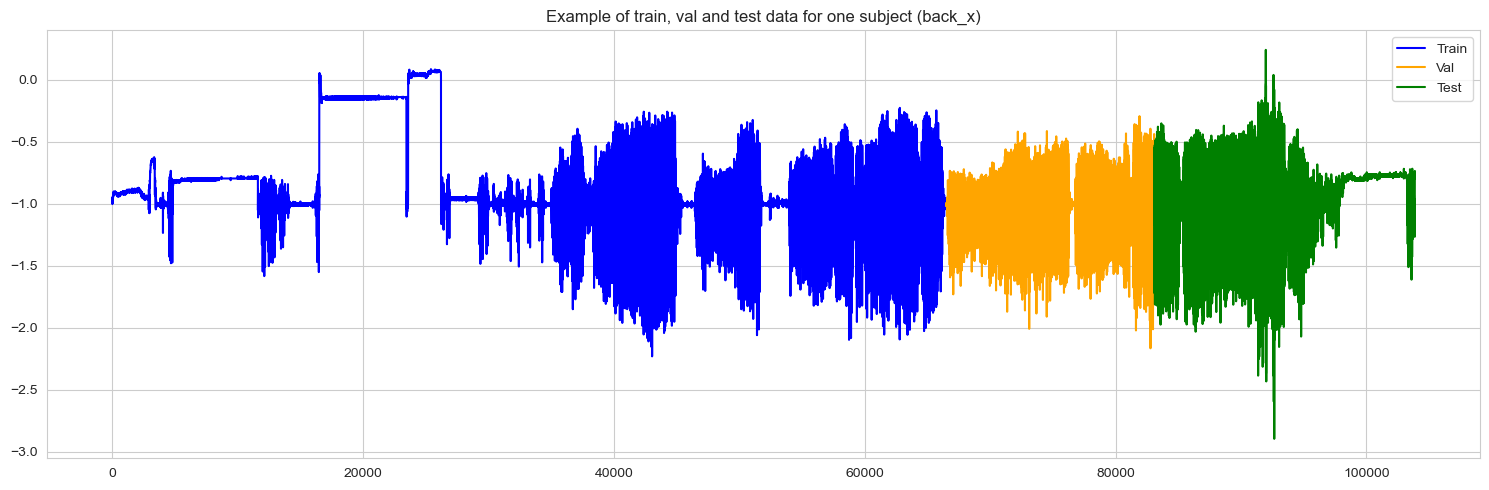

In [12]:
# Lets plot the data on a graph, colouring by whether it is train, val or test data
# Plot the column for back_x

train_set, val_set, test_set = data_preparation.get_sets()

plt.figure(figsize=(15, 5))

plt.plot(train_set[0]['back_x'], label='Train', color='blue')
plt.plot(val_set[0]['back_x'], label='Val', color='orange')
plt.plot(test_set[0]['back_x'], label='Test', color='green')
plt.legend()
    
plt.title(f'Example of train, val and test data for one subject (back_x)')
plt.tight_layout()
plt.show()

In [13]:
# Now we need to create the ESN

# We can star by defining the input weights for the data

# To do this, we will create a matrix of shape (n_neurons, n_features) where n_neurons is the number of neurons in the reservoir and n_features is the number of features in the input signal
# We will then populate this matrix from a density function where elements are 1 for a value p, and 0 for a value of 1-p
# This will give us a sparse matrix with a density of p

n_features = 6
density_1 = 0.9
density_2 = 0.9
n_neurons_1 = 250
n_neurons_2 = 250

# Generate the input weights
input_weights_1 = generate_input_weights(n_neurons_1, n_features, density_1, 'uniform')

# Check the shape of the input weights
print(f'Res1 Input weights shape: {input_weights_1.shape}')

input_weights_2 = generate_input_weights(n_neurons_2, n_neurons_1, density_2, 'uniform')

# Check the shape of the input weights
print(f'Res2 Input weights shape: {input_weights_2.shape}')


Res1 Input weights shape: (250, 6)
Res2 Input weights shape: (250, 250)


In [16]:
# Next, we initialise the ESN
# We will use the BasicESN class from the reservoir.BasicESN module

class_weights = data_preparation.get_class_weights()

leakage_rate_1 = 0.95
spectral_radius_1 = 0.9
gamma_1 = 1.0
W_in_1 = input_weights_1

leakage_rate_2 = 0.5
spectral_radius_2 = 0.7
gamma_2 = 1.0
W_in_2 = input_weights_2

esn = HierarchyESN(leakage_rate_1=leakage_rate_1, spectral_radius_1=spectral_radius_1, gamma_1=gamma_1, W_in_1=W_in_1, n_neurons_1=n_neurons_1,
                     leakage_rate_2=leakage_rate_2, spectral_radius_2=spectral_radius_2, gamma_2=gamma_2, W_in_2=W_in_2, n_neurons_2=n_neurons_2,
                   class_weights=class_weights)

[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.95, spectral_radius_1: 0.9, gamma_1: 1.0, n_neurons_1: 250, leakage_rate_2: 0.5, spectral_radius_2: 0.7, gamma_2: 1.0, n_neurons_2: 250


In [117]:
# Now we need to train the ESN
# We will train the ESN using the training data

X_train_scaled, y_train_encoded = data_preparation.get_preprocessed_data('train')
X_val_scaled, y_val_encoded = data_preparation.get_preprocessed_data('val')
X_test_scaled, y_test_encoded = data_preparation.get_preprocessed_data('test')

# As a test, lets only take the first 1000 samples
n_samples = 500000
data_in = X_train_scaled
data_out = y_train_encoded

esn.fit(data_in, data_out, x_val=X_val_scaled, y_val=y_val_encoded)


100%|██████████| 1357646/1357646 [03:06<00:00, 7276.26it/s]


Shape of previous_states: (1357646, 400)
Shape of state before fitting: (1357646, 400)
Shape of y before fitting: (1357646, 7)


In [121]:
# Now we can use the ESN to predict the output for the test data
y_pred = esn.forward(X_test_scaled)

# Check the shape of the predicted output
y_pred.shape


100%|██████████| 562547/562547 [01:43<00:00, 5437.56it/s]


Shape of previous_states: (562547, 400)


(562547, 7)

In [122]:
# Get the first few rows of the predicted output
y_pred[:5]

array([[ 5.49415822e-01,  7.33053432e-02, -1.65925531e-04,
         3.06764482e-03,  4.56641779e-01, -8.38485671e-02,
         1.58390398e-03],
       [ 5.20637258e-01,  7.19345640e-02, -4.94472077e-04,
         2.26522496e-03,  4.84210583e-01, -7.43281743e-02,
        -4.22498373e-03],
       [ 5.33464191e-01,  6.14845892e-02,  7.63781434e-04,
         4.11357373e-03,  3.83042525e-01,  3.33249931e-02,
        -1.61936527e-02],
       [ 6.39225990e-01,  5.30794912e-02,  1.07100078e-03,
         3.51566916e-03,  3.21871654e-01, -2.48147074e-02,
         6.05090233e-03],
       [ 7.19344755e-01,  4.64294626e-02,  1.86185825e-03,
         4.23309506e-03,  2.59379151e-01, -6.65529749e-02,
         3.53046528e-02]])

In [123]:
# The predicted output is a one-hot encoded array, so we need to decode it back to the original labels
y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)

# Check the shape of the decoded output
y_pred_decoded.shape

(562547, 1)

In [124]:
# Get the first few rows of the decoded output
y_pred_decoded[:5]

array([[1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

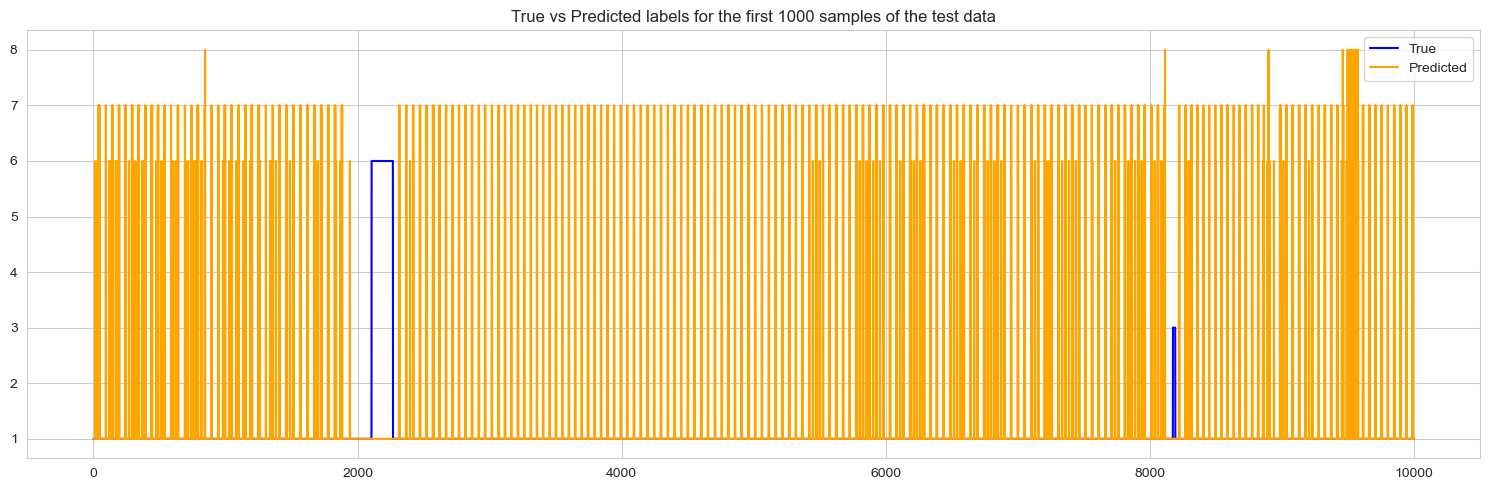

In [127]:
# Now we can evaluate the accuracy of the ESN on the test data
# Start by plotting the true label and the predicted label on a graph

y_test_decoded = data_preparation.get_decoded_labels('test')

plt.figure(figsize=(15, 5))
plt.plot(y_test_decoded[:10000], label='True', color='blue')
plt.plot(y_pred_decoded[:10000], label='Predicted', color='orange')
plt.legend()
plt.title('True vs Predicted labels for the first 1000 samples of the test data')

plt.tight_layout()
plt.show()

In [128]:
# Now we can calculate the accuracy of the ESN on the test data
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_decoded, y_pred_decoded)

accuracy

0.6957711977843629

In [129]:
# Now we can calculate the confusion matrix for the ESN on the test data
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

conf_matrix

array([[317639,      0,      0,      0,  22641,   6227,     74],
       [ 17973,      0,      0,      0,   1658,      9,      0],
       [  2450,      0,      0,      0,     70,    188,      0],
       [   352,      0,      0,      0,      5,     13,      0],
       [119339,      0,      0,      0,  22454,      3,      0],
       [   141,      0,      0,      0,      0,  43063,      0],
       [     0,      0,      0,      0,      0,      0,   8248]],
      dtype=int64)

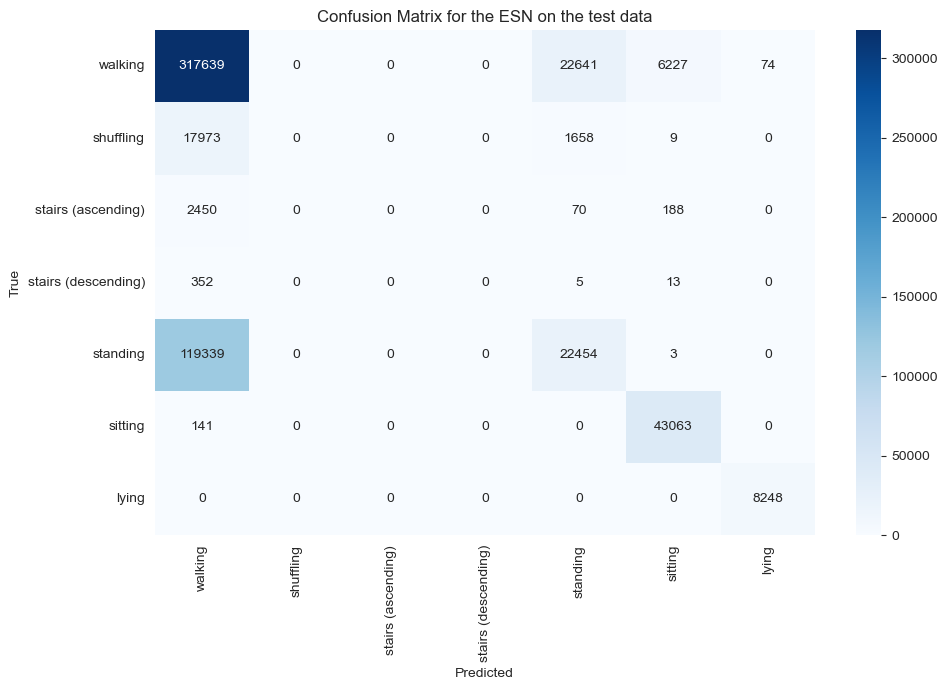

In [130]:
# Now we can plot the confusion matrix
# Our labels are 
# 1: walking	
# 3: shuffling
# 4: stairs (ascending)
# 5: stairs (descending)
# 6: standing
# 7: sitting
# 8: lying
# So we will use these labels for the x and y axis of the confusion matrix
import seaborn as sns

labels = ['walking', 'shuffling', 'stairs (ascending)', 'stairs (descending)', 'standing', 'sitting', 'lying']

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion Matrix for the ESN on the test data')

plt.tight_layout()
plt.show()


In [ ]:
# Let's print a normalised confusion matrix as there is a class imbalance
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Normalised Confusion Matrix for the ESN on the test data')

plt.tight_layout()
plt.show()

In [131]:
# Now we can calculate the precision, recall and f1-score for the ESN on the test data
from sklearn.metrics import classification_report

report = classification_report(y_test_decoded, y_pred_decoded, target_names=labels)

print(report)

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

            walking       0.69      0.92      0.79    346581
          shuffling       0.00      0.00      0.00     19640
 stairs (ascending)       0.00      0.00      0.00      2708
stairs (descending)       0.00      0.00      0.00       370
           standing       0.48      0.16      0.24    141796
            sitting       0.87      1.00      0.93     43204
              lying       0.99      1.00      1.00      8248

           accuracy                           0.70    562547
          macro avg       0.43      0.44      0.42    562547
       weighted avg       0.63      0.70      0.63    562547



C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
